# 量化投资和智能投顾
### 武汉大学《金融科技》课程组

本次项目作业为智能量化投资，即利用人工智能技术开展金融市场投资。我们将搭建一套完整的智能投资框架，并运用中国股票市场数据进行回溯测试。
1. 因子的含义及计算方法；
2. 检验单因子模型的投资收益（量化选股）；
3. 构建基于机器学习的多因子投资模型。


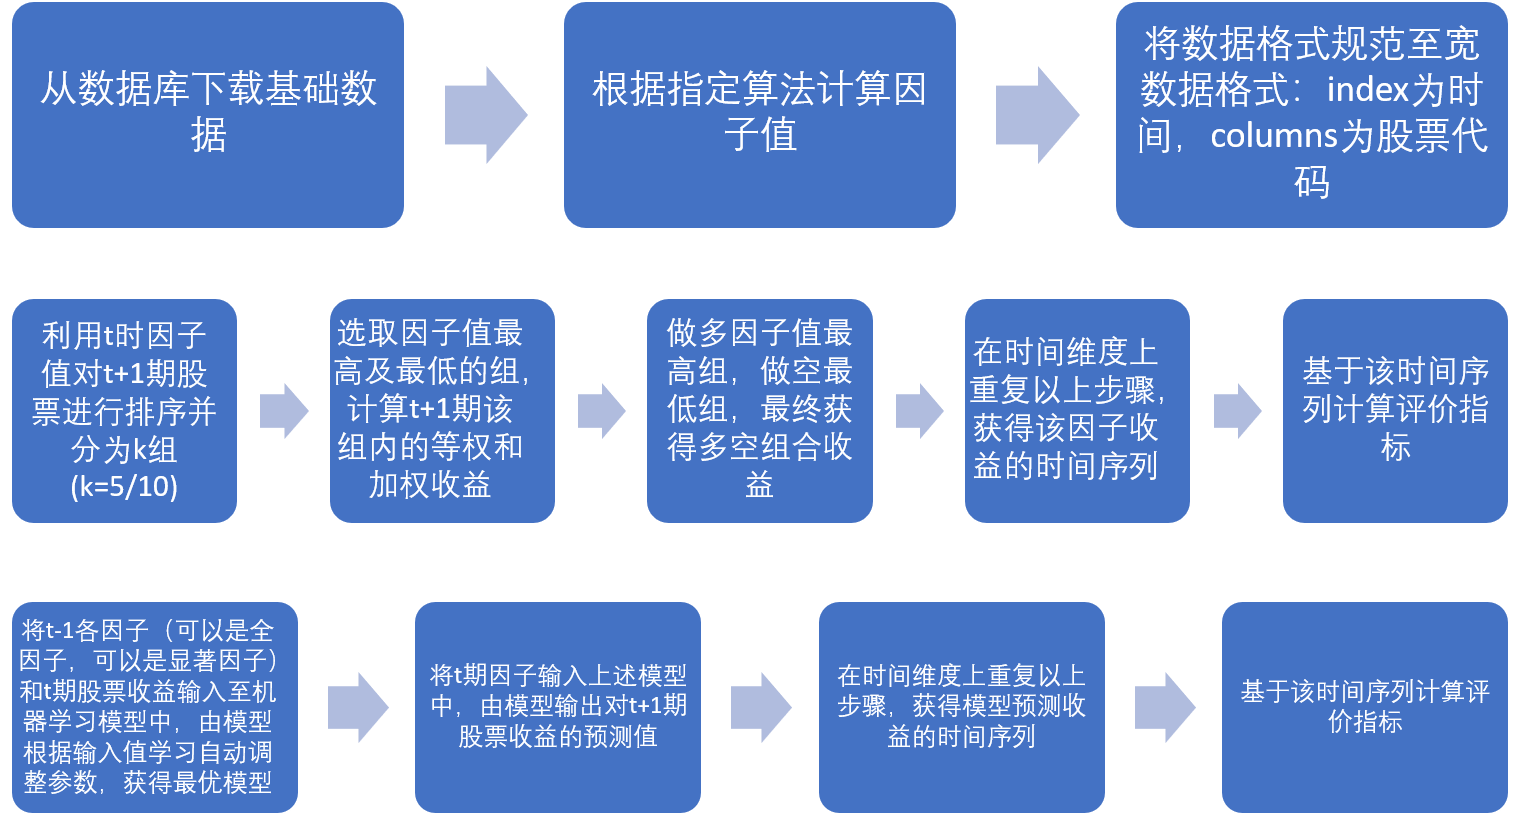

In [1]:
import glob
import os
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.metrics import mean_absolute_error  #平方绝对误差
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

pd.set_option('display.width', 1000)

os.chdir(r'F:\金融科技')
path = os.getcwd()

#设置因子保留的起止年份
startyear = 1997
endyear = 2019

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

D:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## 第一部分：数据收集

根据基本面数据进行交易采用月度交易频率。首先需要准备所有个股的超额收益数据。<br>
国泰安数据中的收益来源为：
首页->数据中心->单表查询->股票市场系列->个股交易数据->月个股回报率文件->考虑现金红利再投资的月个股回报率

其次需要准备基本面因子数据。需要从国泰安(或万德等金融数据库)下载财务数据和量价数据，计算可得到月度因子数据(其他频率的数据可自行探索)。样本为所有A股股票，样本区间为199612-201911，收益区间为199701-201912。
作业需要同学们收集两个常见因子：因子动量mom6和资产市值比AM，其他因子可从GitHub下载。Github数据区间截止2018年底，可以将两个因子截至相同时间（2018年底）。
两个因子的计算方式如下。
1. 动量因子mom6=使用过去6个月的收益计算，但剔除最近的一个月收益，要求数据不少于五个月：为了计算动量因子mom6，需要准备股票过去6个月的收益数据，计算累积收益即可。
2. 资产市值比AM=季末总资产/季末流通市值：计算得到资产市值比，需要计算得到上市公司的季末总资产和季末流通市值。

查阅国泰安数据库说明可知，计算上述两个因子所需的基础数据如下：
1. 过去6个月的收益：首页->数据中心->单表查询->股票市场系列->个股交易数据->月个股回报率文件->考虑现金红利再投资的月个股回报率
2. 资产总计：首页->数据中心->单表查询->公司研究系列->财务报表->资产负债表->资产总计
3. 流通市值：首页->数据中心->单表查询->股票市场系列->个股交易数据->月个股回报率文件->月个股流通市值

## 问题1：列出万科公司2019年1月的收益率和2018年12月流通市值?

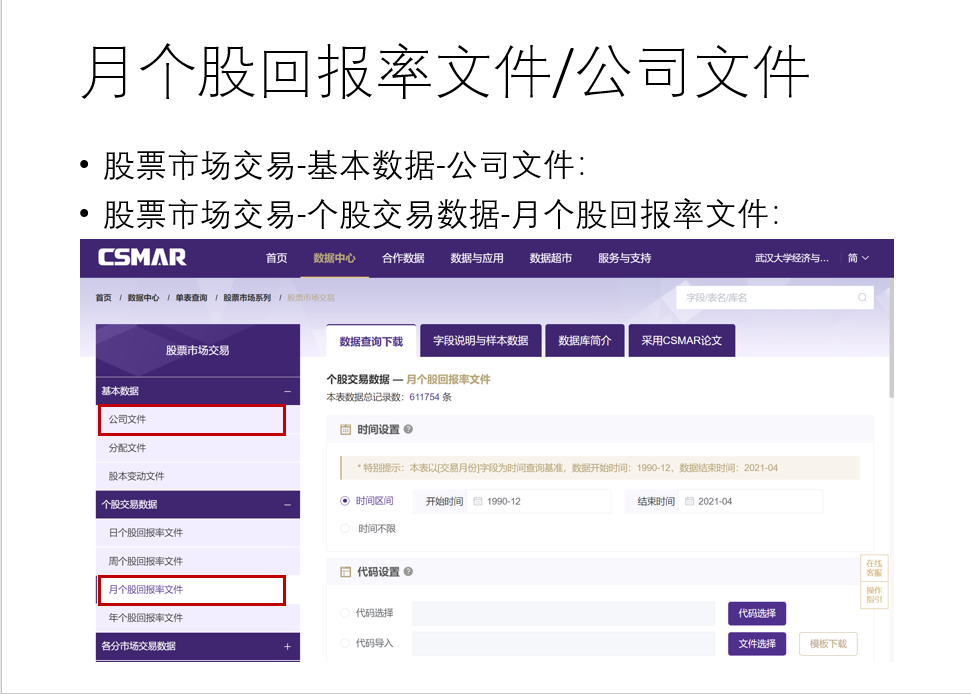

Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准<br>
Stknme [证券简称] - 以交易所公布的中文简称为准<br>
Listdt [上市日期] - 以YYYY-MM-DD表示，上市日期为此股票证券代码的上市日期.<br>
Cuntrycd [国家代码] - 本数据库以10表示中国<br>
Conme [公司全称] - 以公司公布的中文名为准<br>
Conme_en [公司英文全称] - 以公司公布的英文名为准<br>
Indcd [行业代码A] - 0001=金融，0002=公用事业，0003=房地产，0004=综合，0005=工业，0006=商业<br>
Indnme [行业名称A] - Finance=金融，Utilities=公用事业，Properties=房地产，Conglomerates=综合，Industrials=工业，Commerce=商业<br>
Nindcd [行业代码B] - 2001版证监会行业分类代码<br>
Nindnme [行业名称B] - 2001版证监会行业分类名称<br>
Nnindcd [行业代码C] - 2012版证监会行业分类代码<br>
Nnindnme [行业名称C] - 2012版证监会行业分类名称<br>
Estbdt [公司成立日期] - 以YYYY-MM-DD列示，部分缺少在相应位置上以00表示，如1993年12月某日表示为1993-12-00<br>
Favaldt [数据库最早交易记录的日期] - 以YYYY-MM-DD列示<br>
Curtrd [数据库中交易数据的计量货币] - A股以人民币元计价，上海B股以美元计价，深圳B股以港币计价，CNY=人民币元，HKD=港币，USD=美元<br>
Ipoprm [股票发行溢价] - 缺少以-9666表示<br>
Ipoprc [发行价格] - 缺少以-9666表示<br>
Ipocur [发行价格的计量货币] - CNY=人民币元，HKD=港币，USD=美元<br>
Nshripo [发行数量] - 缺少值以-9666表示<br>
Parvcur [股票面值的计量货币] - 计量货币：人民币元，CNY=人民币元<br>
Ipodt [发行日期] - 以YYYY-MM-DD表示<br>
Parval [股票面值] - <br>
Sctcd [区域码] - 1=上海，2=深圳<br>
Statco [公司活动情况] - A=正常交易，D＝终止上市，S=暂停上市， N=停牌<br>
Crcd [AB股交叉码] - A股和B股的交叉码，指同时拥有A股和B股的公司的A（B）股对应的B（A）股代码<br>
Statdt [情况变动日] - 以YYYY-MM-DD表示<br>
Commnt [H股交叉码] - NULL：表示没有交叉码<br>
Markettype [市场类型] - 1=上海A，2=上海B，4=深圳A，8=深圳B, 16=创业板， 32=科创板。

In [2]:
#读取公司上市信息文件
stock = pd.read_csv(os.path.join(path, '数据', 'TRD_Co.csv')) 
stock.head()

,Stkcd,Stknme,Listdt,Cuntrycd,Conme,Conme_en,Indcd,Indnme,Nindcd,Nindnme,...,Nshripo,Parvcur,Ipodt,Parval,Sctcd,Statco,Crcd,Statdt,Commnt,Markettype
0,1,平安银行,1991-04-03,10,平安银行股份有限公司,"Ping An Bank Co., Ltd.",1,金融,I01,银行业,...,350.0,CNY,1989-03-10,20.0,2,A,NaN,2020-09-11,NaN,4
1,2,万科A,1991-01-29,10,万科企业股份有限公司,"China Vanke Co., Ltd.",3,房地产,J,房地产业,...,28000.0,CNY,1988-12-28,1.0,2,A,NaN,2020-09-11,2202.0,4
2,3,PT 金田A,1991-07-03,10,金田实业(集团)股份有限公司,"Gintian Industry (Group) Co., Ltd.",4,综合,M,综合类,...,452.0,CNY,1989-02-28,1.0,2,D,NaN,2002-06-14,NaN,4
3,4,国华网安,1991-01-14,10,深圳国华网安科技股份有限公司,"Shenzhen Cau Technology Co., Ltd.",2,公用事业,G87,计算机应用服务业,...,12500.0,CNY,1989-12-23,1.0,2,A,NaN,2020-09-11,NaN,4
4,5,世纪星源,1990-12-10,10,深圳世纪星源股份有限公司,Shenzhen Fountain Corporation,2,公用事业,K99,其他社会服务业,...,44339.0,CNY,1990-03-03,1.0,2,A,NaN,2020-09-11,NaN,4


In [4]:
#保留所有A股，修改上市年份的格式
stock = stock[stock['Markettype'].isin([1,4,16,32])]
stock['listyear'] = stock['Listdt'].apply(lambda x: float(x[:4]))
stock = stock[stock['listyear'] <= endyear]
stock['stkcd'] = stock['Stkcd'].apply(lambda x : str(int(x)).zfill(6)) 
stks = pd.DataFrame(columns = stock['stkcd'])
print(stks)

Empty DataFrame
Columns: [000001, 000002, 000003, 000004, 000005, 000006, 000007, 000008, 000009, 000010, 000011, 000012, 000013, 000014, 000015, 000016, 000017, 000018, 000019, 000020, 000021, 000022, 000023, 000024, 000025, 000026, 000027, 000028, 000029, 000030, 000031, 000032, 000033, 000034, 000035, 000036, 000037, 000038, 000039, 000040, 000042, 000043, 000045, 000046, 000047, 000048, 000049, 000050, 000055, 000056, 000058, 000059, 000060, 000061, 000062, 000063, 000065, 000066, 000068, 000069, 000070, 000078, 000088, 000089, 000090, 000096, 000099, 000100, 000150, 000151, 000153, 000155, 000156, 000157, 000158, 000159, 000166, 000301, 000333, 000338, 000400, 000401, 000402, 000403, 000404, 000405, 000406, 000407, 000408, 000409, 000410, 000411, 000412, 000413, 000415, 000416, 000417, 000418, 000419, 000420, ...]
Index: []

[0 rows x 3873 columns]


In [6]:
#月个股收益率原始文件
retm = pd.read_csv(os.path.join(path,'数据','TRD_Mnth.csv')) 
retm.head()

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,Msmvosd,Msmvttl,Ndaytrd,Mretwd,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M
0,1,1991-04,3,49.00,30,43.68,13400,615000.0,1157520.00,2118487.47,20,NaN,NaN,4,1991-04-03,NaN,NaN
1,1,1991-05,2,43.46,31,38.34,187800,7675000.0,1016010.00,1859496.56,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN
2,1,1991-06,1,38.53,28,33.99,30600,1094000.0,900735.00,1648520.81,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN
3,1,1991-07,1,33.65,31,29.54,6100,194043.0,782810.00,1432695.05,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN
4,1,1991-08,1,29.39,31,15.00,3243100,49576242.0,674833.82,1346274.65,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN


Stkcd [证券代码] - 以上交所、深交所公布的证券代码为准<br>
Trdmnt [交易月份] - 以YYYY-MM表示<br>
Opndt [月开盘日期] - 以DD表示，为OPNPRC的所在日，“DD”＝本月无交易<br>
Mopnprc [月开盘价] - <br>
Clsdt [月收盘日期] - 以DD表示，为CLSPRC的所在日，“DD”＝本月无交易<br>
Mclsprc [月收盘价] - <br>
Mnshrtrd [月个股交易股数] - 月内该股票的交易数量<br>
Mnvaltrd [月个股交易金额] - 月内该股票的交易金额;A股以人民币元计，上海B以美元计，深圳B以港币计<br>
Msmvosd [月个股流通市值] - 个股的流通股数与月收盘价的乘积。 A股以人民币元计，上海B以美元计，深圳B以港币计，注意单位是千<br>
Msmvttl [月个股总市值] - 个股的发行总股数与月收盘价的乘积，A股以人民币元计，上海B股以美元计，深圳B股以港币计，注意单位是千<br>
Ndaytrd [月交易天数] - 月内实际交易的天数<br>
Mretwd [考虑现金红利再投资的月个股回报率] - 字段说明见“回报率计算方法”<br>
Mretnd [不考虑现金红利再投资的月个股回报率] - 字段说明见“回报率计算方法”<br>
Markettype [市场类型] - 1=上海A，2=上海B，4=深圳A，8=深圳B, 16=创业板， 32=科创板。<br>
Capchgdt [最新股本变动日期] - 上市公司最近一次股本发生变化的日期<br>
Ahshrtrd_M [月盘后成交总量] - 月科创板股票盘后总成交量。<br>
Ahvaltrd_M [月盘后成交总额] - 月科创板股票盘后总成交额。

In [7]:
#整理格式
retm['month'] = retm['Trdmnt'].apply(lambda x : float(x[:4]+x[5:7])) 
retm = retm[['Stkcd','month','Mretwd','Msmvosd','Msmvttl']]
retm = retm.astype(float)
retm.columns = ['stkcd','month','return','mktcap','mktcap_ttl']
retm['stkcd'] = retm['stkcd'].apply(lambda x : str(int(x)).zfill(6))
retm['return'] = retm['return'] * 100
retm['mktcap'] = retm['mktcap'] * 1000
retm['mktcap_ttl'] = retm['mktcap_ttl'] * 1000

retm = pd.merge(stock['stkcd'], retm, on = 'stkcd', how = 'left')
retm.head()

,stkcd,month,return,mktcap,mktcap_ttl
0,000001,199104.0,NaN,1.157520e+09,2.118487e+09
1,000001,199105.0,-12.2253,1.016010e+09,1.859497e+09
2,000001,199106.0,-11.3459,9.007350e+08,1.648521e+09
3,000001,199107.0,-13.0921,7.828100e+08,1.432695e+09
4,000001,199108.0,-41.1588,6.748338e+08,1.346275e+09


In [11]:
#保留月份池
mths = pd.DataFrame(index = retm['month'].drop_duplicates().sort_values())


In [9]:
#打印问题1答案
print('万科2019年1月的股票收益为：{}'.format(retm[(retm['stkcd']=='000002')&(retm['month']==201901)]['return'].values[0]))
print('万科2019年1月末的股票市值为：{}'.format(retm[(retm['stkcd']=='000002')&(retm['month']==201901)]['mktcap'].values[0]))


万科2019年1月的股票收益为：16.4987
万科2019年1月末的股票市值为：269595968690.0


## 问题2：查看2018年12月所有上市公司"资产总计"分布(列出均值、方差、最小值、25、50、75分位数、最大值、样本数、缺失值数等)。观察上述问题2可以发现，部分数据存在着缺失值，请思考：如何处理缺失值？为什么？

In [12]:
fin_data = pd.read_csv(os.path.join(path,'数据','财务数据.csv')) #财务数据
fin_data.head(-1)

,Stkcd,Accper,Typrep,A001000000,A003000000,B002000000
0,1,1990-12-31,A,2.919190e+09,2.365100e+08,NaN
1,1,1991-12-31,A,4.354460e+09,5.779600e+08,NaN
2,1,1992-12-31,A,7.522847e+09,5.456622e+08,NaN
3,1,1993-12-31,A,9.337871e+09,1.189130e+09,2.733111e+08
4,1,1994-06-30,A,1.246595e+10,1.512913e+09,NaN
...,...,...,...,...,...,...
440385,900951,2004-09-30,B,NaN,NaN,1.222607e+07
440386,900951,2006-03-31,B,NaN,NaN,-5.425051e+07
440387,900951,2006-06-30,B,NaN,NaN,-7.611752e+07
440388,900951,2006-09-30,B,NaN,NaN,-8.283955e+07


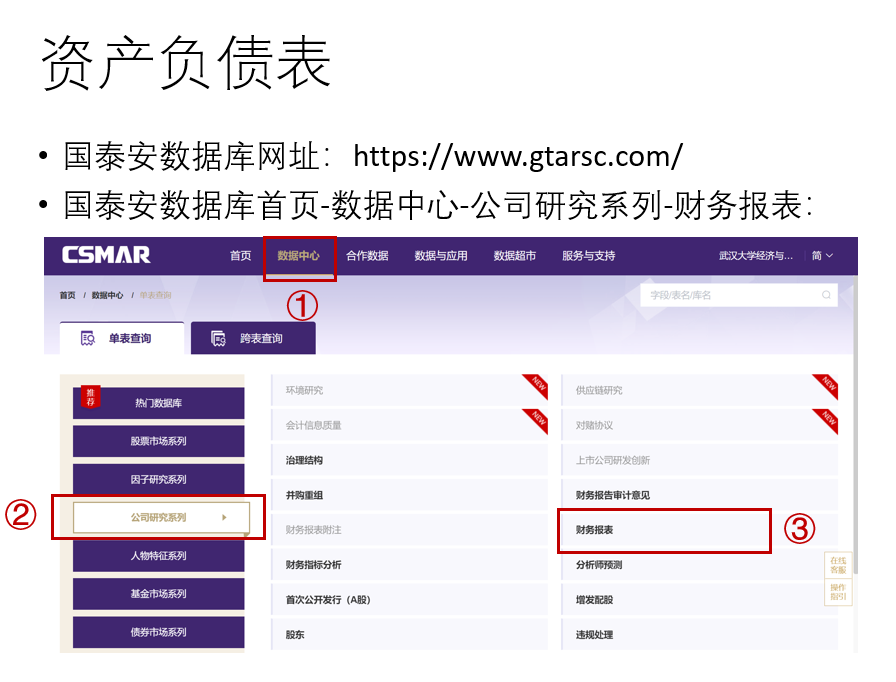

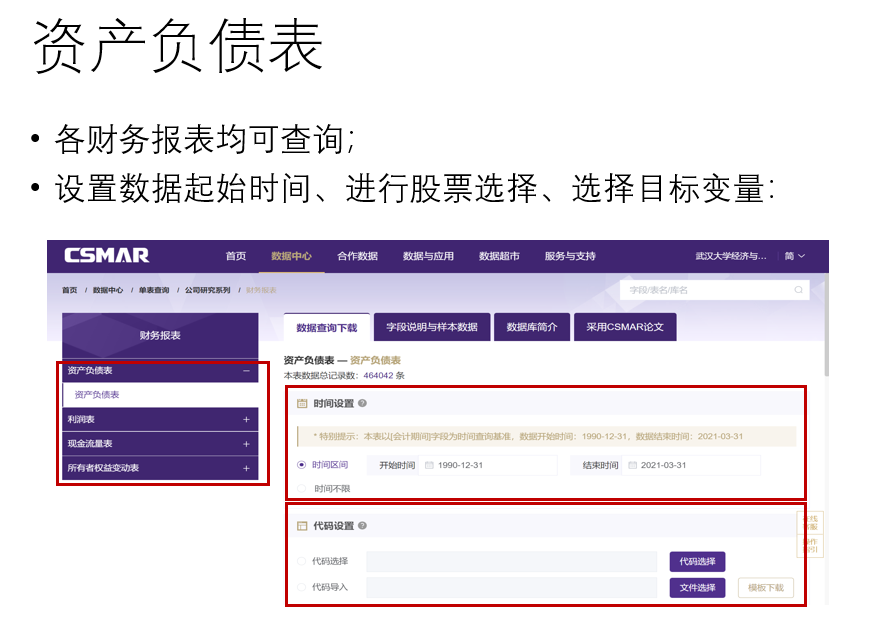

Stkcd [证券代码] - 以上海交易所、深圳证券交易所公布的证券代码为准<br>
Accper [会计期间] - YYYY-MM-DD，前四位表示会计报表公布年度<br>
Typrep [报表类型] - 指上市公司的财务报表中反映的是合并报表或者母公司报表。“A＝合并报表”、“B＝母公司报表”。<br>
A001000000 [资产总计] - 资产各项目之总计。1990年起使用<br>
A003000000 [所有者权益合计] - 股东权益各项目之合计。1990年起使用<br>
B002000000 [净利润] - 公司实现的净利润。注：1990年起使用，1994年前部分公司无此项。

In [13]:
#数据处理
fin_data = fin_data[fin_data['Typrep'] == 'A'] #保留合并报表
fin_data['stkcd'] = fin_data['Stkcd'].apply(lambda x : str(int(x)).zfill(6))
fin_data['month'] = fin_data['Accper'].apply(lambda x:float(x[:4]+x[5:7])) #将月份转成数值型
fin_data = fin_data.iloc[:,3:] #删除掉无用的前三列
fin_data = fin_data[fin_data['month']%100!=1] #删掉1月的数据
fin_data = fin_data[~fin_data['month'].isin([199306,199406,199703,200109])] #缺失严重
fin_data = fin_data.replace('',np.nan)

fin_data.head()

,A001000000,A003000000,B002000000,stkcd,month
0,2.919190e+09,2.365100e+08,NaN,000001,199012.0
1,4.354460e+09,5.779600e+08,NaN,000001,199112.0
2,7.522847e+09,5.456622e+08,NaN,000001,199212.0
3,9.337871e+09,1.189130e+09,2.733111e+08,000001,199312.0
5,1.548841e+10,1.659833e+09,3.563280e+08,000001,199412.0


In [14]:
#财报月份池
mths_sheet = pd.DataFrame(index = fin_data['month'].drop_duplicates().sort_values())


In [15]:
#定义函数，保留所需股票，扩充月份
def expand_data(data,stks,mths):
    # data = asset
    data = pd.concat([stks, data], axis=0,join='inner',sort=False)
    data = pd.concat([stks, data], axis=0,join='outer',sort=False)
    data = pd.concat([mths, data], axis=1,join='outer',sort=False) 
    return data


In [16]:
#总资产
asset = fin_data[['stkcd','month','A001000000']]#总资产
asset = asset.pivot_table(values='A001000000',index=['month'],columns=['stkcd'])
asset = expand_data(asset,stks,mths_sheet)
asset.head()


,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199012.0,2.919190e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199112.0,4.354460e+09,5.684941e+08,6.078172e+08,1.340786e+08,NaN,NaN,NaN,NaN,6.642928e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199212.0,7.522847e+09,9.455016e+08,1.018333e+09,3.224412e+08,6.138121e+08,2.288015e+08,1.322528e+08,1.082672e+08,1.546114e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199312.0,9.337871e+09,2.136159e+09,1.921612e+09,7.718936e+08,6.920086e+08,5.557977e+08,3.135394e+08,2.408760e+08,3.270337e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199412.0,1.548841e+10,2.675188e+09,2.480284e+09,8.914801e+08,1.113737e+09,5.024273e+08,4.566644e+08,2.562639e+08,5.244665e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#问题2结果
print('2018年12月末上市公司资产总计的描述性统计：\n{}'.format(asset.loc[201812,:].astype(float).describe()))
print('缺失值个数为：{}'.format(asset.loc[201812,:].isnull().sum()))

2018年12月末上市公司资产总计的描述性统计：
count    3.591000e+03
mean     6.750525e+10
std      8.668771e+11
min      1.700856e+07
25%      1.839068e+09
50%      4.125631e+09
75%      1.067368e+10
max      2.769954e+13
Name: 201812.0, dtype: float64
缺失值个数为：282


## 问题3：请将"资产总计"中的缺失值填充为截⾯中值(或均值)，并列出处理缺失值之后的"资产总计"分布。

In [18]:
#描述性统计函数
def describe_data(factor):
    # factor = asset
    des=[] #资产总计描述性统计
    for i in range(factor.shape[0]):
        des.append(factor.iloc[i,:].astype(float).describe())
    des = np.mean(pd.DataFrame(des),axis=0)
    num_nan = np.mean(factor.isnull().sum(axis=1)) #平均缺失值个数
    return des,num_nan


In [19]:
#描述性统计
des_asset,num_nan_asset=describe_data(asset)
print('上市公司资产总计的描述性统计：\n{}'.format(des_asset))
print('平均缺失个数为：{}'.format(num_nan_asset))

上市公司资产总计的描述性统计：
count    1.907074e+03
mean     3.174319e+10
std      3.975196e+11
min      2.923579e+07
25%      1.054553e+09
50%      2.169085e+09
75%      5.216526e+09
max      1.164460e+13
dtype: float64
平均缺失个数为：1965.9255319148936


In [20]:
#最近可得数据填充
assetf=asset.fillna(method='ffill')
des_assetf,num_nan_assetf=describe_data(assetf)
print('上市公司资产总计最新可得数据填充后的描述性统计：\n{}'.format(des_assetf))
print('平均缺失个数为：{}'.format(num_nan_assetf))

上市公司资产总计最新可得数据填充后的描述性统计：
count    1.963404e+03
mean     3.089812e+10
std      3.914908e+11
min      2.301233e+07
25%      1.026870e+09
50%      2.138611e+09
75%      5.175830e+09
max      1.164620e+13
dtype: float64
平均缺失个数为：1909.595744680851


In [21]:
#截面均值填充
assetm=pd.DataFrame(index=asset.index,columns=asset.columns)
mean_cross=list(asset.mean(axis=1))
for i in range(asset.shape[0]):#i=0
    #print(i)
    assetm.iloc[i,:]=asset.iloc[i,:].fillna(mean_cross[i])
des_assetm,num_nan_assetm=describe_data(assetm)
print('上市公司资产总计截面均值填充后的描述性统计：\n{}'.format(des_assetm))
print('平均缺失个数为：{}'.format(num_nan_assetm))

上市公司资产总计截面均值填充后的描述性统计：
count    3.873000e+03
mean     3.174319e+10
std      3.325163e+11
min      2.923579e+07
25%      2.129607e+09
50%      9.468719e+09
75%      2.304521e+10
max      1.164460e+13
dtype: float64
平均缺失个数为：0.0


In [22]:
'''
#截面中值填充。
assetmd=pd.DataFrame(index=asset.index,columns=asset.columns)
mean_cross=list(asset.median(axis=1))
for i in range(asset.shape[0]):#i=0
    #print(i)
    assetmd.iloc[i,:]=asset.iloc[i,:].fillna(mean_cross[i])
des_assetmd,num_nan_assetmd=describe_data(assetmd)
print('上市公司资产总计截面中值填充后的描述性统计：\n{}'.format(des_assetmd))
print('平均缺失个数为：{}'.format(num_nan_assetmd))
'''


"\n#截面中值填充。\nassetmd=pd.DataFrame(index=asset.index,columns=asset.columns)\nmean_cross=list(asset.median(axis=1))\nfor i in range(asset.shape[0]):#i=0\n    #print(i)\n    assetmd.iloc[i,:]=asset.iloc[i,:].fillna(mean_cross[i])\ndes_assetmd,num_nan_assetmd=describe_data(assetmd)\nprint('上市公司资产总计截面中值填充后的描述性统计：\n{}'.format(des_assetmd))\nprint('平均缺失个数为：{}'.format(num_nan_assetmd))\n"

## 问题4：查看万科公司1996年12月-2019年11月的动量、AM分布，并作图列出该因子的时序图(x轴为时间，y轴为因子)。

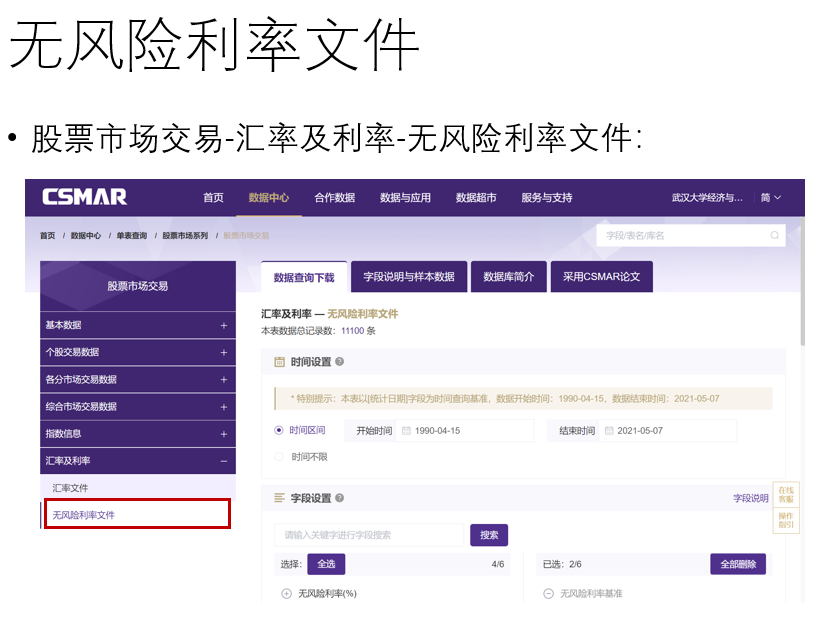

In [23]:
#无风险利率
rf = pd.read_csv(os.path.join(path,'数据','NRI01.csv')) # NRI01 = 定期-整存整取-一年利率
rf.head()

,Nrr1,Clsdt,Nrrdata,Nrrdaydt,Nrrwkdt,Nrrmtdt
0,NRI01,1990-04-15,10.08,0.0263,0.1849,0.8035
1,NRI01,1990-08-21,8.64,0.0227,0.1595,0.6930
2,NRI01,1990-12-19,8.64,0.0227,0.1595,0.6930
3,NRI01,1990-12-20,8.64,0.0227,0.1595,0.6930
4,NRI01,1990-12-21,8.64,0.0227,0.1595,0.6930


Nrr1 [无风险利率基准] - NRI01=定期-整存整取-一年利率；TBC=国债票面利率<br>
Clsdt [统计日期] - 统计截止日期，YYYY-MM-DD<br>
Nrrdata [无风险利率(%)] - <br>
Nrrdaydt [日度化无风险利率(%)] - 根据复利计算方法，将年度的无风险利率转化为日度数据<br>
Nrrwkdt [周度化无风险利率(%)] - 根据复利计算方法，将年度的无风险利率转化为周度数据<br>
Nrrmtdt [月度化无风险利率(%)] - 根据复利计算方法，将年度的无风险利率转化为月度数据<br>

In [24]:
#转化月份格式，并将其设为index
rf['month'] = rf['Clsdt'].apply(lambda x:x[:4]+x[5:7])
rf = rf[['month','Nrrmtdt']].astype(float)
rf.columns = ['month','rf']
rf = rf.drop_duplicates('month').set_index('month')
print(rf)


              rf
month           
199004.0  0.8035
199008.0  0.6930
199012.0  0.6930
199101.0  0.6930
199102.0  0.6930
...          ...
202009.0  0.1241
202010.0  0.1241
202011.0  0.1241
202012.0  0.1241
202101.0  0.1241

[364 rows x 1 columns]


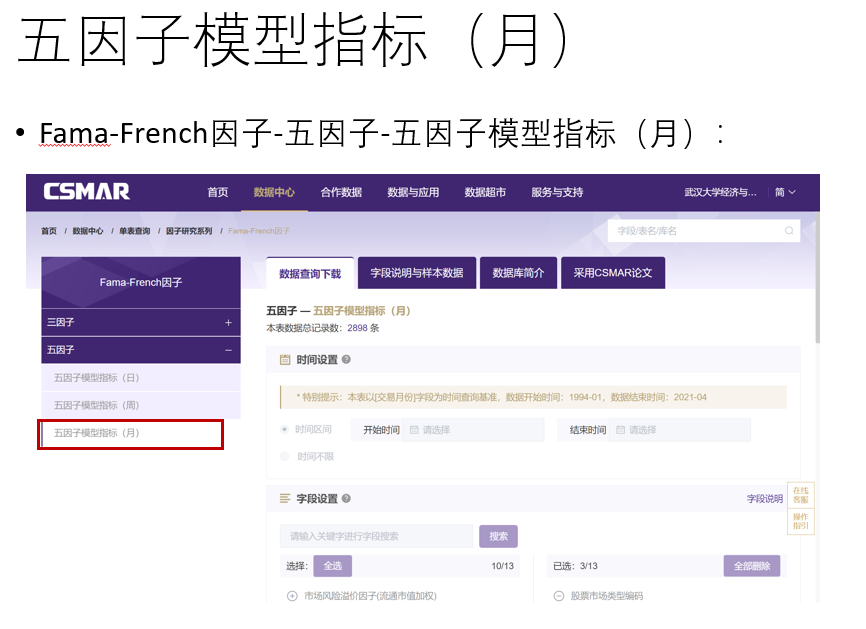

MarkettypeID [股票市场类型编码] - P9709：综合A股和创业板；P9713：综合A股和科创板 P9714：综合A股和创业板和科创板。<br>
TradingMonth [交易月份] - 以YYYY-MM表示, MM表示为该年的第MM月<br>
Portfolios [投资组合类型] - 投资组合类型1代表2*3投资组合划分方法、投资组合类型2代表2*2投资组合划分方法、投资组合类型3代表2*2*2*2投资组合划分方法<br>
RiskPremium1 [市场风险溢价因子(流通市值加权)] - 考虑现金红利再投资的月市场回报率(流通市值加权平均法)与月度化无风险利率之差（央行公布三月定存基准利率）。<br>
RiskPremium2 [市场风险溢价因子(总市值加权)] - 考虑现金红利再投资的月市场回报率(总市值加权平均法)与月度化无风险利率之差（央行公布三月定存基准利率）。<br>
SMB1 [市值因子(流通市值加权)] - 小盘股组合和大盘股组合的月收益率之差。组合月收益率的计算采用流通市值加权。<br>
SMB2 [市值因子(总市值加权)] - 小盘股组合和大盘股组合的月收益率之差。组合月收益率的计算采用总市值加权计算。<br>
HML1 [帐面市值比因子(流通市值加权)] - 高账面市值比组合和低账面市值比组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>
HML2 [帐面市值比因子(总市值加权)] - 高账面市值比组合和低账面市值比组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>
RMW1 [盈利能力因子（流通市值加权)] - 高盈利股票组合和低盈利组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>
RMW2 [盈利能力因子（总市值加权)] - 高盈利股票组合和低盈利组合的月收益率之差。组合投资月收益率的计算采用总市值加权。<br>
CMA1 [投资模式因子（流通市值加权)] - 低投资比例股票组合和高投资比例股票组合的月收益率之差。组合投资月收益率的计算采用流通市值加权。<br>
CMA2 [投资模式因子（总市值加权)] - 低投资比例股票组合和高投资比例股票组合的月收益率之差。组合投资月收益率的计算采用总市值加权。

In [25]:
#ff五因子数据
ff5 = pd.read_csv(os.path.join(path,'数据','STK_MKT_FIVEFACMONTH.csv')) 
ff5 = ff5[ff5['MarkettypeID']=='P9714'] #综合A股、创业板、科创板
ff5 = ff5[ff5['Portfolios']==1]  #2*3投资组合划分方法
ff5['month']=ff5['TradingMonth'].apply(lambda x:x[:4]+x[5:])
ff5 = ff5[['month','RiskPremium1','SMB1','HML1','RMW1','CMA1']].astype(float)
ff5.columns = ['month','mkt_rf','smb','hml','rmw','cma']
ff5 = ff5.sort_values(by='month').set_index('month')
ff5 = ff5*100
ff5 = pd.concat([ff5,rf],axis=1,join='inner')
ff5.head()


,mkt_rf,smb,hml,rmw,cma,rf
month,,,,,,
199401.0,-10.755,8.6776,6.0706,-1.7942,-0.7488,0.8719
199402.0,0.645,-0.7701,-1.4234,0.7726,2.2981,0.8719
199403.0,-11.255,14.2331,-0.7590,-2.0578,10.9919,0.8719
199404.0,-16.555,3.7085,-4.4640,9.0100,6.0269,0.8719
199405.0,-7.255,-0.6646,-5.7334,2.4934,-9.4238,0.8719


In [26]:
#股票池A，全A股
retA = retm[['stkcd','month','return']]
retA = pd.merge(retA, rf, how='left', on=['month'],sort=False)
retA['ret'] = retA['return']-retA['rf']
retA = retA.pivot_table(values='ret',index=['month'],columns=['stkcd'])
retA = expand_data(retA,stks,mths)
retA = retA[(retA.index>=startyear*100)&(retA.index<=endyear*100+12)]
retA.head(5)


,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199701.0,15.8627,6.1791,4.0114,6.7557,8.5260,9.1844,33.6260,17.0058,5.0418,6.9247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,-0.8101,-0.6022,3.0362,14.6626,17.1610,-4.7577,12.3978,10.6972,-0.8762,16.8978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,41.5853,27.8414,16.4191,16.1546,6.5008,31.2376,43.5718,41.2760,19.5901,50.0361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,34.0132,40.6234,-12.6931,-22.5929,34.0476,31.3102,32.3901,-11.3357,-12.7165,4.7650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199705.0,-9.0648,-11.9927,-15.8039,3.2554,-7.7411,-7.2398,-12.5637,-19.1393,-11.2654,-22.5861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#创建文件夹保存过程数据
out_path=os.path.join(path,'过程数据')
if not os.path.exists(out_path):
    os.mkdir(out_path)

In [ ]:
# retA.to_csv(os.path.join(path,'过程数据','retA.csv'))
# retA = pd.read_csv(os.path.join(path,'过程数据','retA.csv'),header=0,index_col=0)

In [28]:
#计算市值size
def get_size(data):
    #长数据转宽数据,扩充股票池
    data = data.astype(float)
    data['stkcd'] = data['stkcd'].apply(lambda x : str(int(x)).zfill(6))
    data=data.pivot_table(values=data.columns[-1],index=['month'],columns=['stkcd'])
    data = expand_data(data,stks,mths)
    data=data[(data.index>=(startyear-1)*100+12)&(data.index<endyear*100+12)]
    return data

#size
size=retm[['stkcd','month','mktcap']] #流通市值
size=get_size(size)
size.head()

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,1.179421e+10,1.812363e+09,1.662511e+09,249108810.0,1.228148e+09,1.146371e+09,3.647564e+08,212449250.0,4.002360e+09,141648660.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,1.373611e+10,1.935264e+09,1.739213e+09,267437890.0,1.340255e+09,1.258562e+09,4.896059e+08,249857260.0,4.228253e+09,152310390.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,1.370755e+10,1.935264e+09,1.802492e+09,308261740.0,1.578327e+09,1.206263e+09,5.532547e+08,278089720.0,4.216669e+09,178964710.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,1.949043e+10,2.485724e+09,2.109299e+09,359916410.0,1.690435e+09,1.904621e+09,7.976497e+08,394548610.0,5.068112e+09,269589390.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,2.623711e+10,3.510479e+09,1.854266e+09,280768130.0,2.276167e+09,2.512432e+09,1.060813e+09,352199920.0,4.454146e+09,284058880.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# size.to_csv(os.path.join(path,'过程数据','size.csv'))
# size = pd.read_csv(os.path.join(path,'过程数据','size.csv'),header=0,index_col=0)

In [ ]:
#mom:过去6个月的累计收益率：要求：至少过去5个月有数据，否则不予计算，且跳过最近一个月的数据
#例：200012的动量是200007、08、09、10、11的数据算出来的，用于对200101排序
ret_mom = retm[['stkcd','month','return']] 
ret_mom = ret_mom.pivot_table(values='return',index=['month'],columns=['stkcd'])
ret_mom = expand_data(ret_mom,stks,mths)
ret_mom = 1+ret_mom/100 #收益率加1
ret_mom = ret_mom[ret_mom.index>199600]

def get_mom(data,n,minimum):
    # data=ret_mom
    # n,minimum = 5,5
    months=data.index
    month=months[n:]
    data0=pd.DataFrame(columns=data.columns,index=month)    
    for i,mon in enumerate(month):
        # i=0
        # mon =month[i]
        data1 = data[(data.index>=months[i])&(data.index<mon)]
        data2 = data1.apply(lambda x: np.prod(x) if len(x.dropna())>=minimum else np.nan) #收益率数据大于最低交易月数时进行连乘，否则缺失
        data0.iloc[i,:]=data2.T.values
        print(month[i]) #如果你想看到本代码的运行进程，可以取消本句注释
    data0=data0-1
    return data0

mom6=get_mom(ret_mom,5,5) #至少5个月有交易
mom6 = expand_data(mom6,stks,mths)
mom6=mom6[(mom6.index>=(startyear-1)*100+12)&(mom6.index<endyear*100+12)]
#mom6.to_csv(os.path.join(path,'过程数据','mom6.csv'))


In [29]:
mom6 = pd.read_csv(os.path.join(path,'过程数据','mom6.csv'),header=0,index_col=0)
mom6.head()

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,0.183540,1.710482,2.332483,0.279695,2.250531,1.728894,1.812044,0.875770,1.460349,1.334958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,0.046232,0.385664,0.469492,-0.284689,0.693728,0.735632,0.510033,-0.008113,0.363187,0.070503,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,0.175321,0.397501,0.504146,0.009434,0.716128,0.952879,1.112083,0.328137,0.327273,0.328903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,0.178638,0.471054,0.523502,0.193549,1.050735,0.597765,1.162678,0.427535,0.394635,0.413534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,0.573487,0.405089,0.151833,-0.120162,0.249534,0.614134,1.113512,0.346988,0.031839,0.569845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# am 资产市值比
def get_am(df,keep='一季报'):
    # df=am
    df = df.astype(float)
    df.columns=['stkcd','month','value']
    df['stkcd'] = df['stkcd'].apply(lambda x : str(int(x)).zfill(6))
    df.loc[(df['value']==np.inf)|(df['value']==-np.inf),'value'] = np.nan
    df=df.dropna() 
    
    df.loc[(df['month']%100==3)|(df['month']%100==9),'annodt'] = df['month']+1
    df.loc[df['month']%100==6,'annodt'] = df['month']+2
    df.loc[df['month']%100==12,'annodt'] = df['month']+100-8

    if keep=='年报': #删除一季报
        df=df[df['month']%100!=3] 
    elif keep=='一季报': #保留一季报，使用最新的填充
        df=df.sort_values(by=['stkcd','month'])   
        df=df.drop_duplicates(subset=['stkcd','annodt'],keep='last') 
        
    df=df.pivot_table(values='value',index=['annodt'],columns=['stkcd'])
    df = expand_data(df,stks,mths)
    df = df.fillna(method='ffill',limit=11)  #最多往后填充11个月，为了避免使用过早的数据
    df=df[(df.index>=(startyear-1)*100+12)&(df.index<endyear*100+12)]
    return df

am=pd.merge(retm[['stkcd','month','mktcap']],fin_data[['stkcd','month','A001000000']],on=['stkcd','month'],how='inner').astype(float)
am['am']= am['A001000000'] / am['mktcap'] 
am=am[['stkcd','month','am']]
am=get_am(am,keep='一季报')
am.head(10)
# am.to_csv(os.path.join(path,'过程数据','am.csv'))

,000001,000002,000003,000004,000005,000006,000007,000008,000009,000010,...,688333,688357,688358,688363,688366,688368,688369,688388,688389,688399
199612.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199701.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199702.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199703.0,2.222873,3.333779,4.053564,2.947168,3.335400,1.381762,3.119088,1.406793,2.520084,2.224428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199704.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199705.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199706.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199707.0,2.545490,1.912489,2.077948,2.643313,1.204090,0.680442,1.647869,1.134463,1.372881,2.002920,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199708.0,1.133167,0.862544,2.236298,2.074215,0.667706,0.875566,0.625550,0.923245,1.362569,1.356210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199709.0,1.133167,0.862544,2.236298,2.074215,0.667706,0.875566,0.625550,0.923245,1.362569,1.356210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#打印结果
mom6_vk=mom6['000002'].astype(float)
print('万科公司的动量的描述性统计：\n{}'.format(mom6_vk.describe()))
print('缺失值个数为：{}'.format(mom6_vk.isnull().sum()))

万科公司的动量的描述性统计：
count    266.000000
mean       0.133531
std        0.383552
min       -0.568748
25%       -0.098139
50%        0.039857
75%        0.259919
max        2.075496
Name: 000002, dtype: float64
缺失值个数为：10


In [33]:
am_vk=am['000002'].astype(float)
print('万科公司的资产总计的描述性统计：\n{}'.format(am_vk.describe()))
print('缺失值个数为：{}'.format(am_vk.isnull().sum()))


万科公司的资产总计的描述性统计：
count    276.000000
mean       2.621397
std        1.638308
min        0.605288
25%        1.305145
50%        1.911075
75%        3.921394
max        6.512774
Name: 000002, dtype: float64
缺失值个数为：0


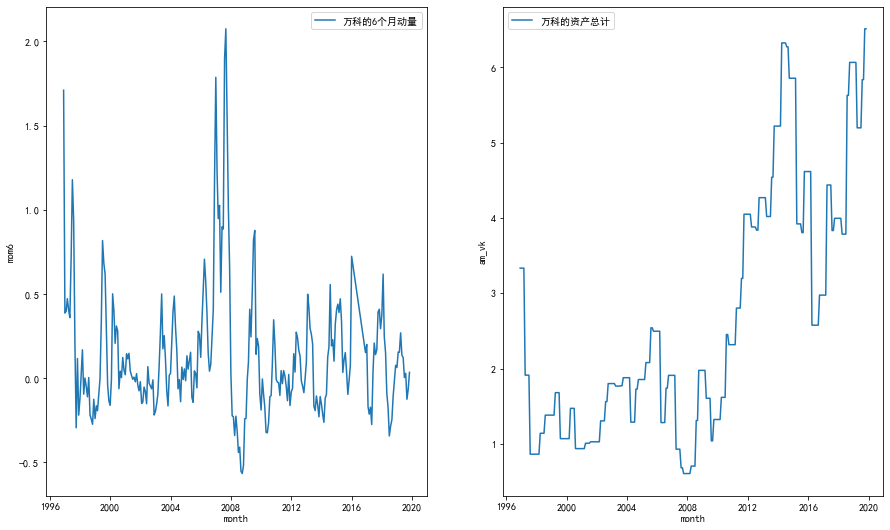

In [34]:
mom6_vk.name, am_vk.name = 'mom6', 'am_vk'

vk_data = pd.concat([mom6_vk,am_vk],axis=1).reset_index()
vk_data['month']=pd.to_datetime(vk_data['index'].apply(lambda x:str(x)[:4]+'-'+str(x)[4:-2]),format='%Y-%m-%d')

fig,ax=plt.subplots(1,2,figsize=(15,9))
sns.lineplot(x='month',y='mom6',data=vk_data,label='万科的6个月动量',ax=ax[0])
sns.lineplot(x='month',y='am_vk',data=vk_data,label='万科的资产总计',ax=ax[1])
plt.show()

## 问题5：列出2018年12月AM升序排序的第一组中前十只股票的AM值，并输出这十只股票在2019年1月的收益。

In [35]:
#问题5的结果
q5 = pd.concat([am.loc[201812,:], retA.loc[201901,:]], axis=1).dropna().reset_index()
q5.columns=['stkcd','am','ret']
q5 = q5.sort_values(by='am')
q5['month'] =201901
print(q5.iloc[:10,:])

       stkcd        am      ret   month
761   002306  0.039229  -4.4719  201901
187   000613  0.040428 -21.2754  201901
2451  600421  0.045025  15.8028  201901
13    000017  0.049691  -7.4635  201901
2833  600870  0.050263  -7.6316  201901
2852  600890  0.052288 -10.6441  201901
101   000503  0.073456 -12.9704  201901
2743  600769  0.077471   0.3887  201901
3227  603288  0.077661   4.9631  201901
1725  300357  0.087954   4.7691  201901


## 问题6：列出2018年12月AM升序排序的10组投资组合和多空组合在2019年1月的月度收益。

In [37]:
#本函数返回分组排序的收益时间序列
def get_group(factor,size,ret,group_num=10):
    # factor=ep
    months = ret.index
    dfew = pd.DataFrame(columns=list(range(1,group_num+1)),index=ret.index)
    dfvw = pd.DataFrame(columns=list(range(1,group_num+1)),index=ret.index)
    for m,month in enumerate(months):
        # m=0
        # month=months[m]
        #print(month)
        final=pd.concat([factor.iloc[m,:],size.iloc[m,:],ret.iloc[m,:]],join='inner',axis=1)
        final.columns=['factor','size','ret']
        final=final.dropna()
        
        if len(final)<=10:
            continue
        else:
            final = final.sort_values(by='factor')
            final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1)
            
            p=[float('-inf')]
            for i in range(1,group_num):
                p.append(np.percentile(final['factor'], 100/ group_num * i))
            p.append(float('inf'))  
            
            k = []  
            for i in range(group_num):
                total =  final[(final['factor']>=p[i])&(final['factor']<=p[i+1])]
                k.append(total)
                
        for j in range(group_num):
           dfew.iloc[m,j]=k[j]['ret'].mean()
           dfvw.iloc[m,j]=k[j]['VW'].sum() / k[j]['size'].sum()
    dfew['high-low']=dfew[group_num]-dfew[1]
    dfvw['high-low']=dfvw[group_num]-dfvw[1]
    dfew=dfew.astype(float)
    dfvw=dfvw.astype(float)
    return  dfew,dfvw
   

In [38]:
#打印结果
am_ew,am_vw = get_group(am,size,retA,10)
print('am因子2019年1月各投资组合等权收益为：\n{}'.format(am_ew.loc[201901,:]))
print('am因子2019年1月各投资组合加权收益为：\n{}'.format(am_vw.loc[201901,:]))

am因子2019年1月各投资组合等权收益为：
1     -2.498574
2     -2.681763
3     -3.729409
4     -2.821602
5     -2.667129
6     -2.130769
7     -2.025092
8     -2.438755
9     -1.969684
10    -0.246918
h-l    2.251656
Name: 201901.0, dtype: float64
am因子2019年1月各投资组合加权收益为：
1      4.672979
2      0.571283
3     -1.933959
4      4.575015
5      0.055963
6     -0.569590
7      1.750591
8      2.360725
9      1.258238
10     5.662257
h-l    0.989278
Name: 201901.0, dtype: float64


## 问题7：绘制1997年1月至2019年12月的10个分位组合的时序收益。x轴为月，y轴为10个分位组合的收益。计算投资组合收益可以按照等权重或市值加权计算。

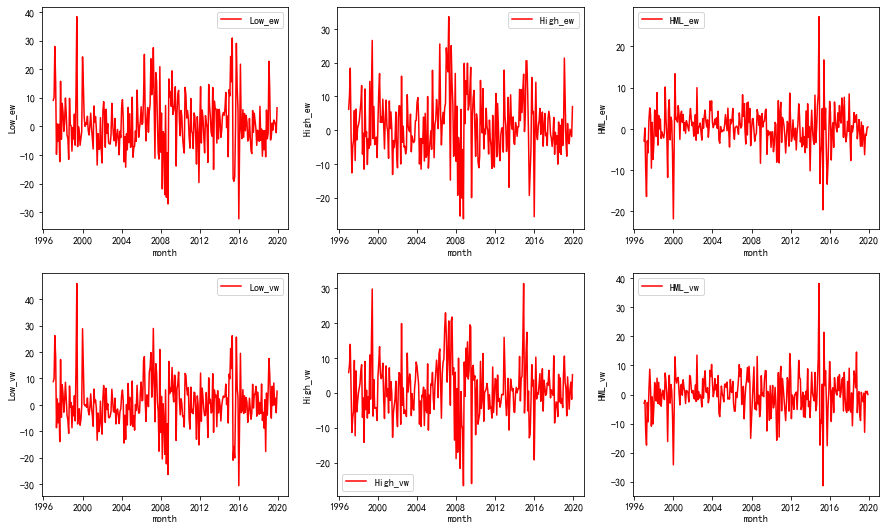

In [39]:
#绘图
am_ev = pd.concat([am_ew.loc[:,[1,10,'h-l']],am_vw.loc[:,[1,10,'h-l']]],axis=1).reset_index()
am_ev.columns =['month','Low_ew','High_ew','HML_ew','Low_vw','High_vw','HML_vw']
am_ev['month']=pd.to_datetime(am_ev['month'].apply(lambda x:str(x)[:4]+'-'+str(x)[4:-2]))
fig,ax=plt.subplots(2,3,figsize=(15,9))
for i in range(2):
    for j in range(3):
        sns.lineplot(x='month',y=am_ev.columns[3*i+j+1],data=am_ev,label=am_ev.columns[3*i+j+1],ax=ax[i,j],color='red')
plt.show()

## 问题8：列出整个投资期内，10个分位数投资组合和多空组合的平均收益、经过Newey-West调整的t值、未经过Newey-West调整的t值、夏普比率、经过CAPM和FF3模型调整后的alpha及NW调整的t值。

In [40]:
#NW-t检验
# As discussed in Newey and West (1994), the choice of lags is arbitrary. 
# Frequently, lags = 4(T∕100)^a , where T is the number of periods in the time series, a = 2∕9 or a = 4∕25.
def NWtest(a, lags=5):
    adj_a = pd.DataFrame(a)
    adj_a=adj_a.dropna()
    if len(adj_a)>0:
        adj_a=adj_a.astype(float)
        adj_a=np.array(adj_a)
        model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
        return float(model.tvalues), float(model.pvalues)
    else:
        return [np.nan]*2
    
def performace_valuation(vb,factor3): 
    # vb=dfew[v]
    vb=vb.dropna()

    data=pd.concat([vb,factor3], axis=1, join='inner')
    data.columns=['factor','mkt_rf','smb','hml','rmw','cma','rf']
    
    #均值
    a=round(np.mean(data['factor']),2)

    #t检验
    t=round(NWtest(data['factor'])[0],2)
    t0=round(stats.ttest_1samp(data['factor'],0)[0],2)
    
    #夏普比率
    std=np.std(data['factor'])
    spr=(np.mean(data['factor']))/std *np.sqrt(12)
    spr=round(spr,2)   
    
    #α检验
    capm=smf.ols('factor~mkt_rf',data).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    c_a=round(capm.params[0],2)
    c_t=round(capm.tvalues[0],2) 
    
    ff3_model=smf.ols('factor~mkt_rf+smb+hml',data).fit(cov_type='HAC',cov_kwds={'maxlags':5})
    ff3_a=round(ff3_model.params[0],2)
    ff3_t=round(ff3_model.tvalues[0] ,2)     
    
    final=pd.DataFrame([a,t,t0,spr,c_a,c_t,ff3_a,ff3_t])
    return final.iloc[:,0]

def get_uni_test(ret,size,factor,factor3):
    # factor=roe
    dfew,dfvw=get_group(factor,size,ret)
    
    resultew=pd.DataFrame(columns=['portfolio','return','NWt','t','spr','capm_a','capm_t','ff3_a','ff3_t'],index=list(range(11)))    
    resultvw=pd.DataFrame(columns=['portfolio','return','NWt','t','spr','capm_a','capm_t','ff3_a','ff3_t'],index=list(range(11)))
    
    vbsew=dfew.columns 
    vbsvw=dfvw.columns 
     
    for i,v in enumerate(vbsew):
        resultew.iloc[i,0]=v
        resultew.iloc[i,1:]=performace_valuation(dfew[v],factor3).values

    for i,v in enumerate(vbsvw):
        resultvw.iloc[i,0]=v
        resultvw.iloc[i,1:]=performace_valuation(dfvw[v],factor3).values  
    resultew.iloc[:,0]=['low','2','3','4','5','6','7','8','9','high','high-low'] 
    resultew = resultew.set_index('portfolio')
    resultvw.iloc[:,0]=['low','2','3','4','5','6','7','8','9','high','high-low']  
    resultvw = resultvw.set_index('portfolio')    
    return resultew,resultvw


In [41]:
results_mom_ew,results_mom_vw = get_uni_test(retA,size,mom6,ff5)
print('mom6单因子检验等权结果为：\n{}'.format(results_mom_ew))
print('mom6单因子检验加权结果为：\n{}'.format(results_mom_vw))

mom6单因子检验等权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         1.04  1.53  1.69  0.35   0.27   0.93 -0.43  -2.4
2           1.13  1.65  1.91   0.4   0.36   1.48 -0.36 -2.74
3           1.43  2.03  2.44  0.51   0.67   2.46 -0.06 -0.48
4           1.44   2.1  2.47  0.52   0.68   2.66 -0.08 -0.81
5           1.38     2  2.37  0.49   0.62   2.46 -0.16 -1.52
6           1.32  1.97  2.31  0.48   0.57   2.36 -0.16 -1.57
7            1.3  1.98  2.29  0.48   0.54   2.42 -0.14  -1.3
8           1.18   1.8  2.09  0.44   0.43   1.95 -0.21 -1.67
9           1.16   1.8  2.07  0.43   0.41    1.9 -0.13 -0.91
high         0.9  1.46  1.58  0.33   0.17    0.7 -0.29 -1.32
high-low   -0.14 -0.51 -0.46  -0.1   -0.1  -0.36  0.14  0.47
mom6单因子检验加权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         0.68  0.99  1.17  0.24   -0.1  -0.41 -0.3

In [42]:
results_am_ew,results_am_vw = get_uni_test(retA,size,am,ff5)
print('am单因子检验等权结果为：\n{}'.format(results_am_ew))
print('am单因子检验加权结果为：\n{}'.format(results_am_vw))

am单因子检验等权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         0.96  1.46  1.62  0.34    0.2   0.78 -0.22  -1.5
2           1.16  1.79  1.99  0.42   0.41   1.65 -0.18 -1.38
3           1.22   1.8  2.07  0.43   0.46   1.72 -0.22    -2
4           1.36  2.04  2.33  0.49    0.6   2.32 -0.09 -0.75
5           1.28  1.89  2.18  0.46   0.52   1.99  -0.2 -1.92
6           1.34  1.98  2.28  0.48   0.58   2.23  -0.2 -1.81
7           1.45  2.13  2.47  0.52   0.69   2.72 -0.12 -1.18
8            1.3  1.95  2.28  0.48   0.55   2.35 -0.19 -1.66
9           1.26  1.85   2.2  0.46   0.49   2.21 -0.25 -2.39
high        1.26  1.88   2.3  0.48   0.51   2.85 -0.14 -0.98
high-low     0.3  1.09  1.01  0.21   0.31   1.19  0.08  0.35
am单因子检验加权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         0.79  1.28  1.42   0.3   0.06   0.27  0.11  0

## 问题9：为什么用NW调整的t值？请查阅资料。并与非NW调整的t值进行比较。

如果序列存在异方差和自相关特性，使得对其标准差的估计存在偏差，从而导致因子显著性检验结果失真。<br>
Newey-West调整通过在计算协方差矩阵时加入自相关调整项，能够有效规避序列自相关对协方差矩阵估计带来的影响。<br>
经过NW调整的t值一般比未调整的t值更小。这说明NW调整能够降低数据“虚假的有效”。

## 问题10：观察动量因子和AM因子的分组收益和多空组合收益，是否随着因子的增大而收益增大？可以参考"投资学"绘制柱形图。

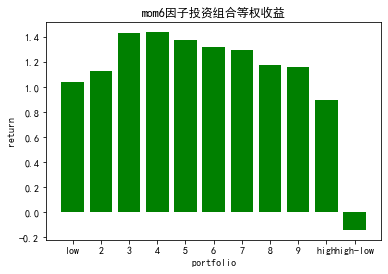

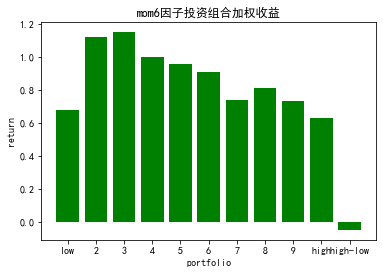

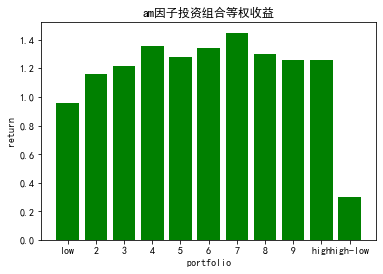

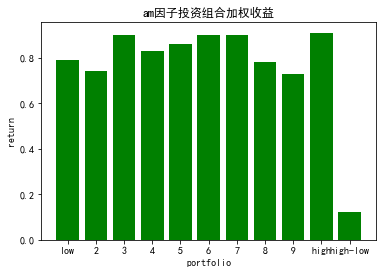

In [43]:
#绘图
def bar(data,title_name):
    # data = results_am_ew
    data = data.astype(float)
    plt.clf()
    y=list(data.iloc[:,0])
    x=list(data.index)
    #fig = plt.figure(0)
    plt.title(title_name)
    plt.xlabel("portfolio")
    plt.ylabel("return")
    c= plt.bar(x,y,color="green")
    c=plt.show()
    return c

bar_mom6ew = bar(results_mom_ew,'mom6因子投资组合等权收益')
bar_mom6vw = bar(results_mom_vw,'mom6因子投资组合加权收益')
bar_amew = bar(results_am_ew,'am因子投资组合等权收益')
bar_amvw = bar(results_am_vw,'am因子投资组合加权收益')

## 问题11：列出等权和市值加权情况下均能取得显著多空组合收益的因子，列出这些因子以及采用这些因子进行投资的绩效评估结果。

In [44]:
file = glob.glob(os.path.join(path, '数据','96个因子','*.csv'))

namelist = []#因子名称
for i in range(len(file)):
    namelist.append(file[i][19:-4])

k=[]
for i in range(len(file)):
    k.append(pd.read_csv(file[i]))


In [45]:
#修改数据格式
def change(k):
    k_index=size.index[:263]
    k2=[]
    for i in range(len(k)):
        #print(i)
        k0=k[i].iloc[:,:264]
        k0.index = k0.iloc[:,0].apply(lambda x : str(int(x)).zfill(6))
        k0 = k0.iloc[:,1:].T
        k0.index = k_index
        k2.append(k0)
    return k2

k2=change(k) 

In [46]:
#将股票收益率数据与因子的格式统一
ret_fin = pd.concat([pd.DataFrame(columns=k2[0].columns),retA.iloc[:263,:]],axis=0,join='inner')

In [ ]:
#汇总各因子10-1组结果
ew_HL=pd.DataFrame(index=namelist,columns=['return','NWt','t','spr','capm_a','capm_t','ff3_a','ff3_t'])
vw_HL=pd.DataFrame(index=namelist,columns=['return','NWt','t','spr','capm_a','capm_t','ff3_a','ff3_t'])

for i in range(len(file)):#i=0
    factor=k2[i]
    k_results_ew,k_results_vw = get_uni_test(ret_fin,k2[0],factor,ff5)
    ew_HL.iloc[i,:], vw_HL.iloc[i,:] = k_results_ew.iloc[-1,:],k_results_vw.iloc[-1,:]
    print(i)
    
# ew_HL.to_csv(os.path.join(path,'过程数据','等权95.csv'))
# vw_HL.to_csv(os.path.join(path,'过程数据','加权95.csv'))


In [47]:
ew_HL = pd.read_csv(os.path.join(path,'过程数据','等权95.csv'), header=0, index_col=0)
vw_HL = pd.read_csv(os.path.join(path,'过程数据','加权95.csv'), header=0, index_col=0)

In [48]:
ew_sig = ew_HL[abs(ew_HL['NWt'])>=1.96]
vw_sig = vw_HL[abs(vw_HL['NWt'])>=1.96]
commonew = ew_sig[ew_sig.index.isin(vw_sig.index)].sort_values(by='NWt',ascending=False)
commonvw = vw_sig[vw_sig.index.isin(ew_sig.index)].sort_values(by='NWt',ascending=False)

print('显著的因子——等权：\n{}'.format(commonew))
print('显著的因子——加权：\n{}'.format(commonvw))

显著的因子——等权：
                   return   NWt     t   spr  capm_a  capm_t  ff3_a  ff3_t
20aeavol             1.19  9.42  6.59  1.14    1.16    9.23   1.24   8.43
75rd_mve             1.16  6.83  5.49  0.94    1.15    7.01   0.69   3.63
17LM                 2.24  6.32  6.29  1.21    2.34    6.23   2.80   7.16
61pchsale_pchrect    0.45  4.75  3.47  0.37    0.45    4.86   0.53   4.96
54egr                1.26  4.60  3.92  0.69    1.29    4.87   2.07   7.03
80chfeps             1.62  3.94  4.60  0.99    1.68    4.24   1.76   4.80
92pchsaleinv         0.33  3.69  3.16  0.21    0.31    3.71   0.38   3.88
16illq               1.38  3.56  3.62  0.65    1.38    3.66   0.28   1.78
55fgr5yr             1.19  3.33  2.89  0.56    1.26    3.56   2.24   7.75
45SGINVG             0.29  3.22  2.88  0.12    0.27    3.21   0.30   3.30
65NOA               -0.88 -2.22 -2.24 -0.60   -0.90   -2.34  -0.24  -1.34
24mom36             -0.68 -2.63 -2.21 -0.63   -0.68   -2.75  -0.00  -0.02
25momchg            -0.81 -

In [ ]:
#移动显著的因子
out_path = os.path.join(path,'显著因子')

if not os.path.exists(out_path):
    os.mkdir(out_path)

files2 = glob.glob(os.path.join(path, '显著因子','*.csv'))
for f in files2:
    os.remove(f)
    
for sig in commonew.index:
    shutil.copy(os.path.join(path, '数据','96个因子',sig+'.csv'), out_path)

## 问题12：统计199701-199801训练样本数和测试样本数。

In [49]:
file_sig = glob.glob(os.path.join(path, '显著因子','*.csv'))
k_sig=[]
for i in range(len(file_sig)):
    k_sig.append(pd.read_csv(file_sig[i]))

k_sig=change(k_sig)  

k_sig.append(ret_fin)

namelist_sig = []#因子名称
for i in range(len(file_sig)):
    namelist_sig.append(file_sig[i][13:-4])
    
namelist_sig.append('ret')


In [50]:
#*****对原始数据进行预处理，每个截面一个Dataframe#
def fill_mean(kl):
    kl_mean_cross=list(kl.mean(axis=0))
    for i in range(kl.shape[1]):#i=0
        #print(i)
        kl.iloc[:,i]=kl.iloc[:,i].fillna(kl_mean_cross[i])
    return kl

timeseries=[]
for i in range(len(ret_fin.index)):#i=0#len(ret.index)
    kl = pd.concat([k_sig[j].iloc[i,:] for j in range(len(namelist_sig))],axis=1,join="outer")
    kl.columns = namelist_sig
    kl = kl[kl['ret'].notna()]
    kl = fill_mean(kl)
    timeseries.append(kl)

len_train=[]#训练集199701-199712
for i in range(12):
    len_train.append(len(timeseries[i]))
len_train=sum(len_train)
len_test=len(timeseries[12])#测试集199801
print('训练集样本数：{}'.format(len_train))
print('测试集样本数：{}'.format(len_test))


训练集样本数：7247
测试集样本数：697


In [51]:
def randomforest(x_train,y_train,x_test,paras):
    clf = RandomForestRegressor(n_estimators=int(paras[0]),max_depth=int(paras[1])) 
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    return prediction

def ols(x_train,y_train,x_test):
    clf2 = LinearRegression()
    clf2.fit(x_train, y_train)
    prediction2 = clf2.predict(x_test)
    return prediction2

def retlist(timeseries,length=12,model='randomforest',para_adj=False,paras=[50,3]):
    #length为滑动窗口长度：取值{12}
    #CLF为机器学习模型
    predict_all=[]
    for i in range(len(timeseries) - (length)):#i=0
        FINALm = pd.concat(timeseries[i:i + (length+1)], axis=0)
        #这里+1是多扩充了1个月，实际上只需要到length就可以了。多扩充的一个月是测试集，而且我们只利用其中的x,用于预测y
        FINAL_X = FINALm.iloc[:, :-1]
        FINAL_x = scale(FINAL_X)
        FINAL_x=pd.DataFrame(FINAL_x,index=FINAL_X.index,columns=FINAL_X.columns)
        final = pd.concat(timeseries[i:i + length], axis=0)
        x_train = FINAL_x[:len(final)].fillna(0)
        x_test = FINAL_x[len(final):].fillna(0)
        y_train = final.iloc[:, -1]
        
        if model=='randomforest':
            if para_adj == False:
                prediction = randomforest(x_train,y_train,x_test,paras)
            else :
                prediction = randomforest(x_train,y_train,x_test,list(paras.iloc[i,:]))
        elif model=='ols':
            prediction = ols(x_train,y_train,x_test)
             
        r_predict = pd.DataFrame(prediction,index=x_test.index,columns=[ret_fin.index[i+length]])#
        predict_all.append(r_predict)
        print(i)
        
    predict_final = pd.concat(predict_all,axis=1).T
    predict_final = expand_data(predict_final,stks,mths)
    predict_final = predict_final[(predict_final.index>=startyear*100)&(predict_final.index<=endyear*100+12)]
    return predict_final


In [ ]:
predict_RF0 = retlist(timeseries,length=12,model='randomforest',paras=[50,3])#0代表没有验证集
#predict_RF0.to_csv(os.path.join(path,'过程数据','predict_RF0.csv'))#输出以备检查和调用

In [ ]:
predict_ols = retlist(timeseries,length=12,model='ols')
#predict_ols.to_csv(os.path.join(path,'过程数据','predict_ols.csv'))

In [52]:
predict_RF0 = pd.read_csv(os.path.join(path,'过程数据','predict_RF0.csv'),header=0,index_col=0)

## 问题13：列出2019年1⽉预期收益最⾼和最低的10只股票，并列出它们的预期收益。

In [53]:
month=201801 #作业布置错误.更改为2018年1月
final=pd.concat([predict_RF0.loc[month],size.loc[201712],ret_fin.loc[month]],join='inner',axis=1)
final.columns=['RF','size','ret']
final=final.dropna()
final = final.sort_values(by='RF')
final.head(10)


,RF,size,ret
300376,-1.517657,1.739819e+10,-6.0686
600107,-1.517657,4.546800e+09,-2.9745
600108,-1.517657,8.001821e+09,-1.8273
600110,-1.517657,1.085895e+10,-11.9885
600111,-1.517657,5.300643e+10,-8.0062
600113,-1.517657,3.256092e+09,7.6058
600116,-1.517657,7.903249e+09,-6.9780
600117,-1.517657,4.217538e+09,-2.5845
600118,-1.517657,2.985785e+10,-6.5399
600119,-1.517657,4.205232e+09,-9.1153


In [54]:
final.tail(10)

,RF,size,ret
300592,20.969935,529380000.0,-11.2224
300538,26.618201,510300000.0,-6.6810
603580,32.989043,507768200.0,-5.9022
300669,32.989043,514041000.0,-7.1675
300640,32.989043,511000000.0,-4.3902
603329,37.014873,500940000.0,155.2119
603283,47.164132,581600000.0,112.8057
002921,153.166927,402400000.0,57.9773
603655,195.106722,246450000.0,197.0802
300684,199.632332,302776800.0,294.4957


## 问题14：计算各组合在2019年1⽉的持仓收益(等权和市值加权)。

In [55]:
#计算2018年1月的持仓收益
final['VW'] = final.apply(lambda x: x['size'] * x['ret'], axis=1) 

dfew201801 = pd.DataFrame(columns=list(range(1,11)),index=['等权组合收益'])
dfvw201801 = pd.DataFrame(columns=list(range(1,11)),index=['加权组合收益'])

p=[float('-inf')]
for i in range(1,10):
    p.append(np.percentile(final['RF'], 10 * i))
p.append(float('inf')) 

k = []  
for i in range(10):
    total =  final[(final['RF']>=p[i])&(final['RF']<=p[i+1])]
    k.append(total)
for j in range(10):
   dfew201801.iloc[0,j]=k[j]['ret'].mean()
   dfvw201801.iloc[0,j]=k[j]['VW'].sum() / k[j]['size'].sum()
dfew201801['hml']=dfew201801[10]-dfew201801[1]
dfvw201801['hml']=dfvw201801[10]-dfvw201801[1]
df201801=pd.concat([dfew201801,dfvw201801],axis=0).astype(float)

print(df201801)

               1         2         3         4         5         6         7         8         9        10       hml
等权组合收益 -3.864182 -3.864182 -3.864182 -3.864182 -3.864182 -3.864182 -3.864182 -3.191355 -0.654420  0.364883  4.229065
加权组合收益 -2.107495 -2.107495 -2.107495 -2.107495 -2.107495 -2.107495 -2.107495  1.433597  4.743353  5.234361  7.341857


## 问题15：按照单因⼦中绩效评估的⽅法对运⽤机器学习⽅法的多因⼦模型的时序收益进⾏绩效评估。

In [56]:
predict_RF0=pd.read_csv(os.path.join(path,'过程数据','predict_RF0.csv'),header=0,index_col=0)

In [57]:
results_RF0_ew,results_RF0_vw = get_uni_test(ret_fin,size,predict_RF0,ff5)
print('RF单因子检验等权结果为：\n{}'.format(results_RF0_ew))
print('RF单因子检验加权结果为：\n{}'.format(results_RF0_vw))

RF单因子检验等权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         0.64  0.91  1.05  0.23   0.02   0.07 -0.69 -4.22
2           1.02  1.41  1.59  0.35   0.41    1.6 -0.39 -2.86
3           1.24  1.74  1.97  0.44   0.46   1.67 -0.33  -2.2
4           1.04  1.39  1.62  0.36    0.4   1.35  -0.4 -2.72
5           1.39  1.99  2.28   0.5   0.65   2.23 -0.14    -1
6           1.24  1.74  2.01  0.44   0.55   2.04  -0.2 -1.55
7           1.66  2.31  2.68  0.59   0.74   2.71 -0.02 -0.18
8           1.46  1.93  2.31  0.52   0.76   2.61 -0.05 -0.37
9            1.4  1.92  2.28   0.5   0.79   2.94  0.11  0.79
high        1.71  2.27  2.74   0.6   1.07   3.32  0.41  2.28
high-low    1.09  4.63  4.67  1.03   1.08   4.59   1.1  5.25
RF单因子检验加权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low         0.38  0.53  0.66  0.15  -0.24  -1.24 -0.56  -

## 问题16：⽐较ols模型与随机森林模型所得收益。可运⽤表格或绘图展示。

In [58]:
predict_ols = pd.read_csv(os.path.join(path,'过程数据','predict_ols.csv'),header=0,index_col=0)

In [59]:
results_ols_ew,results_ols_vw = get_uni_test(ret_fin,size,predict_ols,ff5)
print('ols单因子检验等权结果为：\n{}'.format(results_ols_ew))
print('ols单因子检验加权结果为：\n{}'.format(results_ols_vw))

ols单因子检验等权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low        -0.09 -0.12 -0.14 -0.03  -0.71  -2.74 -1.18  -6.1
2           0.51  0.73  0.85  0.19  -0.12  -0.49 -0.74 -4.57
3           0.86  1.21   1.4  0.31   0.22    0.8 -0.46 -3.38
4           1.06  1.46  1.73  0.38   0.42    1.5 -0.34 -2.77
5           1.13  1.56  1.83   0.4   0.49   1.72  -0.3 -2.28
6           1.51  2.09  2.45  0.54   0.87   3.12  0.05  0.42
7           1.57  2.11  2.53  0.55   0.92   3.21  0.15   1.1
8           1.72  2.36  2.76   0.6   1.07   3.87  0.25  2.02
9           1.88  2.61  3.06  0.67   1.24    4.2  0.45  3.38
high        2.18  2.92  3.36  0.74   1.53   4.76  0.86  3.55
high-low    2.26  7.37  7.84  1.72   2.24   7.53  2.04  6.94
ols单因子检验加权结果为：
          return   NWt     t   spr capm_a capm_t ff3_a ff3_t
portfolio                                                   
low        -0.06 -0.08  -0.1 -0.02  -0.67   -4.2 -0.65 

In [60]:
#比较ols与随机森林的结果
q16ew = pd.concat([results_RF0_ew.iloc[-1,:],results_ols_ew.iloc[-1,:]],axis=1).T
q16vw = pd.concat([results_RF0_vw.iloc[-1,:],results_ols_vw.iloc[-1,:]],axis=1).T
q16ew.index = q16vw.index = ['Random Forest','ols']  
print('RF和ols多空组合等权收益为：\n{}'.format(q16ew))
print('RF和ols多空组合加权收益为：\n{}'.format(q16vw))

RF和ols多空组合等权收益为：
              return   NWt     t   spr capm_a capm_t ff3_a ff3_t
Random Forest   1.09  4.63  4.67  1.03   1.08   4.59   1.1  5.25
ols             2.26  7.37  7.84  1.72   2.24   7.53  2.04  6.94
RF和ols多空组合加权收益为：
              return   NWt     t   spr capm_a capm_t ff3_a ff3_t
Random Forest   0.63   2.6   2.4  0.53   0.63   2.63  0.69  2.81
ols             1.24  5.12  4.96  1.09   1.25   5.33  1.18  4.64


## 问题17：给出201812获得的最优参数。

In [ ]:
#纠正为 201811
#每月更新一次超参数的选择
def get_parameters():
    factor_num=len(file_sig)
    train_len=11#代表11个月
    parameters = []
    for i in range(0,len(timeseries)-train_len,1):#i=0
    #for i in range(0,10):#i=0
        #step=1:每月重新计算超参数；step=12，每年末重新计算超参数
        #最早能够对收益做出预测的是1998年1月。投资组合也从这里开始。
        #我们获得的最佳参数时间点分别为199712、199801、199802、···
        #为了和x_test对应（x_test标号从199801开始，我们将获得的最优参数从199801开始进行标记
        train=pd.concat(timeseries[i:train_len+i],axis=0)
        x_train=np.array(train.iloc[:,:factor_num].fillna(0)) #因子
        y_train=np.array(train.iloc[:,factor_num]) #最后一列是收益
        
        validation=timeseries[train_len+i]
        x_vali=np.array(validation.iloc[:,:factor_num].fillna(0))
        y_vali=np.array(validation.iloc[:,factor_num])
        
        parameter = []
        
        for ne in [50,100]:
            for md in [3,4]:
                clf=RandomForestRegressor(n_estimators=ne, max_depth=md)
                clf.fit(x_train,y_train)
                prediction = clf.predict(x_vali)
                perf = mean_absolute_error(prediction, y_vali)
                parameter.append([md,ne,perf])
        parameters.append(parameter)
        print(i)
    parameters = pd.DataFrame(parameters)
    return parameters

parameters =  get_parameters()    
#parameters.to_csv(os.path.join(path,'过程数据','parameters.csv'))

In [ ]:
parameters=pd.read_csv(os.path.join(path,'过程数据','parameters.csv'),index_col=0)


In [59]:
parameters=parameters.iloc[:-1,:]#best_params最后一个月是多算的，不用于预测。
parameters.index=ret_fin.index[(ret_fin.index>199800)&(ret_fin.index<202000)]

def get_best_para(parameters):
    best_para = pd.DataFrame(columns=['md','ne','mae'],index=parameters.index)
    for i in range(len(parameters)):
        # i=0
        para1 = pd.DataFrame(parameters.iloc[i,:])
        para2 = []
        for j in range(len(para1)):
            para2.append(para1.iloc[j,0].replace('[','').replace(']','').replace("'","").replace(" ","").split(','))
        para2 = pd.DataFrame(para2,columns=['md','ne','mae']).astype(float)  
        para2 = para2.sort_values(by='mae')
        best_para.iloc[i,:] = para2.iloc[0,:]
    best_para.iloc[:,:2] = best_para.iloc[:,:2].astype(int)
    return best_para
        
best_params_all =  get_best_para(parameters)      
#best_params_all.to_csv(os.path.join(path,'过程数据','best_params_all.csv'))

In [ ]:
best_params_all = pd.read_csv(os.path.join(path,'过程数据','best_params_all.csv'),index_col=0,header=0)

In [ ]:
print(('2018年11月最优超参数为：\n{}'.format(best_params_all.loc[201811,:])))

## 问题18：按照单因子中绩效评估的方法对调参后机器学习方法的多因子模型的时序收益进行绩效评估。

In [ ]:
#这里的算法和未进行超参数调整的算法基本一致，只是在使用机器学习的时候每次选择我们已算好的最优超参数。

predict_RF1=retlist(timeseries,length=12,model='randomforest',para_adj=True,paras=best_params_all)
#predict_RF1.to_csv(os.path.join(path,'过程数据','predict_RF1.csv'))

In [ ]:
predict_RF1 = pd.read_csv(os.path.join(path,'过程数据','predict_RF1.csv'),index_col=0,header=0)

In [ ]:
results_RF1_ew,results_RF1_vw = get_uni_test(ret_fin,size,predict_RF1,ff5)
print('随机森林调参后的模型的单因子检验等权结果为：\n{}'.format(results_RF1_ew))
print('随机森林调参后的模型的单因子检验等权结果为：\n{}'.format(results_RF1_vw))